In [1]:
import tensorflow as tf
from tensorflow import keras


class Network(monoidal.Box):
    def __init__(self, dom, cod, model):
        self.model = model
        super().__init__("Network", dom, cod)

    def then(self, other):
        inputs = keras.Input(shape=(len(self.dom),))
        output = self.model(inputs)
        output = other.model(output)
        composition = keras.Model(inputs=inputs, outputs=output)
        return Network(self.dom, other.cod, composition)

    def tensor(self, other):
        dom = len(self.dom) + len(other.dom)
        cod = len(self.cod) + len(other.cod)
        inputs = keras.Input(shape=(dom,))
        model1 = keras.layers.Lambda(
            lambda x: x[:, :len(self.dom)],)(inputs)
        model2 = keras.layers.Lambda(
            lambda x: x[:, len(self.dom):],)(inputs)
        model1 = self.model(model1)
        model2 = other.model(model2)
        outputs = keras.layers.Concatenate()([model1, model2])
        model = keras.Model(inputs=inputs, outputs=outputs)
        return Network(PRO(dom), PRO(cod), model)

    @staticmethod
    def id(dim):
        inputs = keras.Input(shape=(len(dim),))
        return Network(dim, dim, keras.Model(inputs=inputs, outputs=inputs))

    @staticmethod
    def dense_model(dom, cod, name=None, hidden_layer_dims=[], activation=tf.nn.relu):
        inputs = keras.Input(shape=(dom,))
        model = inputs
        for dim in hidden_layer_dims:
            model = keras.layers.Dense(dim, activation=activation)(model)
        outputs = keras.layers.Dense(cod, activation=activation)(model)
        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        return Network(PRO(dom), PRO(cod), model)

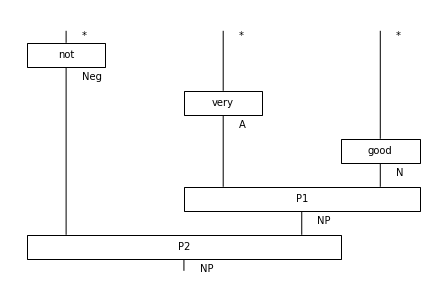

In [13]:
from discopy.monoidal import Ty, Id, Box

n, a, np, neg, star = Ty('N'), Ty('A'), Ty('NP'), Ty('Neg'), Ty('*')
not_, very, good = Box('not', star, neg), Box('very', star, a), Box('good', star, n)
P1, P2 = Box('P1', a @ n, np), Box('P2', neg @ np, np)

diagram = not_ @ very @ good >> Id(neg) @ P1 >> P2
diagram.draw()

In [21]:
from discopy.monoidal import Functor

dim = 5
ob = lambda x: PRO(dim)
ar = lambda box: Network.dense_model(len(box.dom) * dim, len(box.cod) * dim, name=box.name)
F = Functor(ob, ar, ob_factory=PRO, ar_factory=Network)
F(diagram).model